@ 모델 학습시 : 1, 2, 3 실행

#1.데이터 불러오기 & 데이터프레임 작업

In [1]:
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
# sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import normalize

In [2]:
# 파일경로와 라벨에 대한 데이터 프레임 만들기

images_dir = '/content/drive/MyDrive/Colab Notebooks/new_data_v3/images'
masks_dir = '/content/drive/MyDrive/Colab Notebooks/new_data_v3/masks'
class_list = sorted(os.listdir(images_dir)) # ['MEL', 'NV', 'Other_SC']
# class_list_mask = sorted(os.listdir(masks_dir))
# print(class_list_mask)

image_pathes = []
mask_pathes = []
labels = []

# file이름의 list들을 file_paths에 저장
for cls in class_list:
  image_class_path = os.path.join(images_dir, cls)
  image_list = sorted(os.listdir(image_class_path))
  mask_class_path = os.path.join(masks_dir, cls)
  mask_list = sorted(os.listdir(mask_class_path))

  for image in image_list:
    image_path = os.path.join(image_class_path, image)
    image_pathes.append(image_path)
    labels.append(cls)
  
  for mask in mask_list:
    mask_path = os.path.join(mask_class_path, mask)
    mask_pathes.append(mask_path)

image_series = pd.Series(image_pathes, name = 'image_pathes')
mask_series = pd.Series(mask_pathes, name = 'mask_pathes')
label_series = pd.Series(labels, name = 'labels')
df = pd.concat([image_series, mask_series, label_series], axis = 1)


In [3]:
df.head()

,image_pathes,mask_pathes,labels
0,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
1,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
2,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
3,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
4,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL


In [4]:
df['image_pathes'].iloc[10000]

'/content/drive/MyDrive/Colab Notebooks/new_data_v3/images/Other_SC/ISIC_0034223.jpg'

In [5]:
df['mask_pathes'].iloc[10000]

'/content/drive/MyDrive/Colab Notebooks/new_data_v3/masks/Other_SC/ISIC_0034223_segmentation.png'

In [6]:
# 데이터프레임 전처리 & 분할


train_df, dummy_df = train_test_split(df, train_size = 0.91, shuffle = True,
                                      random_state = 123, stratify = df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size = 0.5,
                                   shuffle = True, random_state = 123, stratify = dummy_df['labels'])
print('train_df의 크기 : {}\ntest_df의 크기 : {}\nvalid_df[validation dataframe]의 크기 : {}'.format(len(train_df), len(test_df), len(valid_df)))

train_labels_count = train_df['labels'].value_counts()
train_labels_count_norm = round(train_df['labels'].value_counts(normalize = True) * 100, 2)
# for b in balance:
#     print (b)


train_df의 크기 : 9113
test_df의 크기 : 451
valid_df[validation dataframe]의 크기 : 451


In [7]:
train_labels_count

NV          6101
Other_SC    1999
MEL         1013
Name: labels, dtype: int64

In [8]:
train_labels_count_norm # 상태가 정상인 라벨이 거의 절반을 차지함 >> 불균형 데이터

NV          66.95
Other_SC    21.94
MEL         11.12
Name: labels, dtype: float64

In [9]:
round(valid_df['labels'].value_counts(normalize = True) * 100, 2)

NV          66.96
Other_SC    21.95
MEL         11.09
Name: labels, dtype: float64

In [10]:
round(test_df['labels'].value_counts(normalize = True) * 100, 2)

NV          66.96
Other_SC    21.95
MEL         11.09
Name: labels, dtype: float64

In [11]:
valid_df['labels'].value_counts()

NV          302
Other_SC     99
MEL          50
Name: labels, dtype: int64

In [12]:
test_df['labels'].value_counts()

NV          302
Other_SC     99
MEL          50
Name: labels, dtype: int64

In [13]:
# 불균형 데이터로 인한 학습문제를 해결하기 위해 undersampling 진행

sample_list = []
max_size = 300 #min(train_labels_count)
min_size = 0

groups = train_df.groupby('labels')

for label in train_df['labels'].unique():                 
    group = groups.get_group(label)
    sample_count = len(group)    

    # 만약 특정라벨을 가지는 train_df의 길이가 max_size 보다 크다면,
    # mix_size만큼의 데이터를 샘플링한 뒤에 samplelist에 넣는다.
    if sample_count > max_size :
        samples = group.sample(max_size, replace = False, weights = None,
                             random_state = 123,
                             axis = 0).reset_index(drop = True)
        sample_list.append(samples)
    elif sample_count >= min_size:
        sample_list.append(group)

train_df = pd.concat(sample_list, axis=0).reset_index(drop = True)
print(len(train_df))
print(train_df['labels'].value_counts())


900
MEL         300
NV          300
Other_SC    300
Name: labels, dtype: int64


In [14]:
train_df = train_df.sample(frac=1)  # row 전체 shuffle

train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset
train_df

,image_pathes,mask_pathes,labels
0,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
1,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV
2,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,Other_SC
3,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV
4,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
...,...,...,...
895,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV
896,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,Other_SC
897,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
898,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,Other_SC


In [15]:
# image, mask, label이 맞게 짝지어졌는 지 확인

def check_pathes(dataframe, num):
  print(dataframe['image_pathes'].iloc[num].split('new_data_v3/')[1])
  print(dataframe['mask_pathes'].iloc[num].split('new_data_v3/')[1])
  print(dataframe['labels'].iloc[num])

check_pathes(valid_df, 19)

images/Other_SC/ISIC_0025417.jpg
masks/Other_SC/ISIC_0025417_segmentation.png
Other_SC


MEL


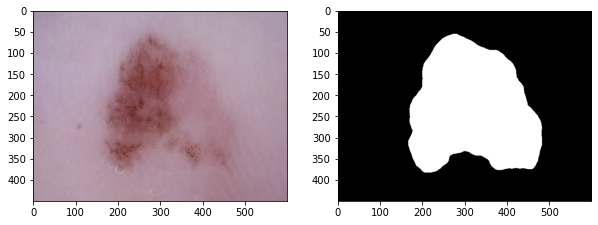

In [16]:
def check_image_mask(dataframe, num):
  image = plt.imread(dataframe['image_pathes'].iloc[num])
  mask = plt.imread(dataframe['mask_pathes'].iloc[num])
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.imshow(image);
  plt.subplot(122)
  plt.imshow(mask, cmap = 'gray');
  print(dataframe['labels'].iloc[num])

check_image_mask(train_df, 4)

In [17]:
train_df.head(20)

,image_pathes,mask_pathes,labels
0,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
1,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV
2,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,Other_SC
3,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV
4,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
5,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV
6,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,Other_SC
7,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
8,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,MEL
9,/content/drive/MyDrive/Colab Notebooks/new_dat...,/content/drive/MyDrive/Colab Notebooks/new_dat...,NV


#2.이미지 데이터 로딩 및 전처리(Train, validation set만)

In [18]:
# 병변 이미지, 마스크 이미지 불러오기 및 사이즈 변경

image_dataset_train = []  # 판다스를 이용할 수도 있지만, 여기서는 리스트를 사용한다.
image_dataset_valid = []

mask_dataset_train = []  # 마스크 이미지와 라벨을 저장하기 위한 리스트
mask_dataset_valid = []

In [19]:

for i in train_df['image_pathes']:
  image = plt.imread(i)
  image = Image.fromarray(image.astype(np.uint8))
  image = image.resize((592, 448))
  image_dataset_train.append(np.array(image))
  
for j in train_df['mask_pathes']:
  mask = cv2.imread(j, 0)
  mask = Image.fromarray(mask.astype(np.uint8))
  mask = mask.resize((592, 448))
  mask_dataset_train.append(np.array(mask))

for i in valid_df['image_pathes']:
  image = plt.imread(i)
  image = Image.fromarray(image.astype(np.uint8))
  image = image.resize((592, 448))
  image_dataset_valid.append(np.array(image))

for j in valid_df['mask_pathes']:
  mask = cv2.imread(j, 0)
  mask = Image.fromarray(mask.astype(np.uint8))
  mask = mask.resize((592, 448))
  mask_dataset_valid.append(np.array(mask))


In [20]:
# 불러온 이미지들의 개수 확인

print('image train 데이터셋 개수 : {}\nimage validation 데이터셋 개수 : {}\nmask train 데이터셋 개수 : {}\nmask validation 데이터셋 개수 : {}'.format(len(image_dataset_train), len(image_dataset_valid), len(mask_dataset_train), len(mask_dataset_valid)))

image train 데이터셋 개수 : 900
image validation 데이터셋 개수 : 451
mask train 데이터셋 개수 : 900
mask validation 데이터셋 개수 : 451


In [21]:
# # 불러온 이미지 체크(훈련)
# import random
# import numpy as np
# image_number = random.randint(0, len(image_dataset_train))
# plt.figure(figsize=(12, 6))
# print('이미지 숫자[0 ~ {}] : {}'.format(len(image_dataset_train) - 1, image_number))
# plt.subplot(121)
# plt.imshow(image_dataset_train[image_number])
# plt.subplot(122)
# plt.imshow(mask_dataset_train[image_number], cmap='gray')

# plt.show()

In [22]:
# 이미지 정규화 및 전처리(딥러닝 학습에 적합하도록...)
image_dataset_train = np.array(image_dataset_train) / 255.
image_dataset_valid = np.array(image_dataset_valid) / 255.


# mask를 정규화를 하지 않으며, 단지 0과 1사이로 rescale한다.
mask_dataset_train = np.expand_dims((np.array(mask_dataset_train)), 3) /255.
mask_dataset_valid = np.expand_dims((np.array(mask_dataset_valid)), 3) /255.

X_train = image_dataset_train
X_valid = image_dataset_valid


y_train = mask_dataset_train
y_valid = mask_dataset_valid


print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(900, 448, 592, 3) (451, 448, 592, 3) (900, 448, 592, 1) (451, 448, 592, 1)


In [23]:
mask_dataset_train[1].shape

(448, 592, 1)

#3.Unet 모델정의, 모델학습 및 결과 저장

In [ ]:
IMG_HEIGHT = 448
IMG_WIDTH  = 592
IMG_CHANNELS = 3
DROPOUT = 0.3

In [ ]:
# Unet 모델 함수 생성 및 인스턴스 Unet 모델 생성

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, DROPOUT):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs
   
    # Downsampling 부분

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    # c1 = BatchNormalization()(c1)
    
    c1 = Dropout(DROPOUT)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    # c1 = BatchNormalization()(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    # c2 = BatchNormalization()(c2)
    c2 = Dropout(DROPOUT)(c2)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    # c2 = BatchNormalization()(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    # print(p2.shape)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    # c3 = BatchNormalization()(c3)
    c3 = Dropout(DROPOUT)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    # c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    # print(p3.shape)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    # c4 = BatchNormalization()(c4)
    c4 = Dropout(DROPOUT)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    # c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    # print(p4.shape)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    # c5 = BatchNormalization()(c5)
    c5 = Dropout(DROPOUT)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # c5 = BatchNormalization()(c5)
    # print(c5.shape)

    # Upsampling 부분
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    # c6 = BatchNormalization()(c6)
    c6 = Dropout(DROPOUT)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    # c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    # c7 = BatchNormalization()(c7)
    c7 = Dropout(DROPOUT)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    # c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    # c8 = BatchNormalization()(c8)
    c8 = Dropout(DROPOUT)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    # c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    # c9 = BatchNormalization()(c9)
    c9 = Dropout(DROPOUT)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    # c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, DROPOUT)

model = get_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 448, 592, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_141 (Conv2D)            (None, 448, 592, 16  448         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_69 (Dropout)           (None, 448, 592, 16  0           ['conv2d_141[0][0]']             
                                )                                                           

In [ ]:
# 모델학습
batch_size = 16
epochs = 30

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, 
                    verbose=1, 
                    epochs=epochs, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=False)

model.save('/content/drive/MyDrive/Colab Notebooks/new_data_v3/skin_seg_models/segmentation_skincance_img450*600*3_data_simpleUNET_train_img_{}_valid_img_{}_batch{}_epoch{}_dropout{}.hdf5'.format(len(X_train), len(X_valid), batch_size, epochs, DROPOUT))

Epoch 1/30
57/57 [==============================] - 11s 160ms/step - loss: 0.5567 - accuracy: 0.7172 - val_loss: 0.4436 - val_accuracy: 0.8245
Epoch 2/30
57/57 [==============================] - 7s 129ms/step - loss: 0.4775 - accuracy: 0.7850 - val_loss: 0.4196 - val_accuracy: 0.8285
Epoch 3/30
57/57 [==============================] - 7s 128ms/step - loss: 0.4637 - accuracy: 0.7921 - val_loss: 0.4295 - val_accuracy: 0.8185
Epoch 4/30
57/57 [==============================] - 7s 128ms/step - loss: 0.4536 - accuracy: 0.7987 - val_loss: 0.4414 - val_accuracy: 0.7897
Epoch 5/30
57/57 [==============================] - 7s 128ms/step - loss: 0.4047 - accuracy: 0.8252 - val_loss: 0.3423 - val_accuracy: 0.8484
Epoch 6/30
57/57 [==============================] - 7s 127ms/step - loss: 0.3782 - accuracy: 0.8376 - val_loss: 0.3342 - val_accuracy: 0.8588
Epoch 7/30
57/57 [==============================] - 7s 127ms/step - loss: 0.3689 - accuracy: 0.8419 - val_loss: 0.3401 - val_accuracy: 0.8566
Epoch

In [ ]:
history.history

{'loss': [0.5566630959510803,
  0.47745540738105774,
  0.4636562168598175,
  0.453561007976532,
  0.40472155809402466,
  0.37823623418807983,
  0.36888250708580017,
  0.3620445430278778,
  0.35913577675819397,
  0.3539465665817261,
  0.3517143428325653,
  0.3487699329853058,
  0.3391253352165222,
  0.33376145362854004,
  0.32719889283180237,
  0.3175012171268463,
  0.30562955141067505,
  0.29804837703704834,
  0.2898792326450348,
  0.2902078330516815,
  0.27842575311660767,
  0.2764524221420288,
  0.267331063747406,
  0.26157692074775696,
  0.264032244682312,
  0.25666946172714233,
  0.2548295557498932,
  0.24753470718860626,
  0.2501678466796875,
  0.24009503424167633],
 'accuracy': [0.7172349691390991,
  0.7849818468093872,
  0.7921314239501953,
  0.7987281084060669,
  0.8252370953559875,
  0.8375766277313232,
  0.8418759107589722,
  0.8454025983810425,
  0.8476789593696594,
  0.8473131060600281,
  0.849468469619751,
  0.8512473702430725,
  0.8551132678985596,
  0.8569185733795166,
 

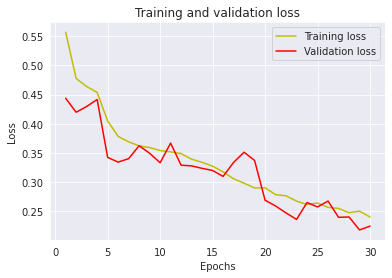

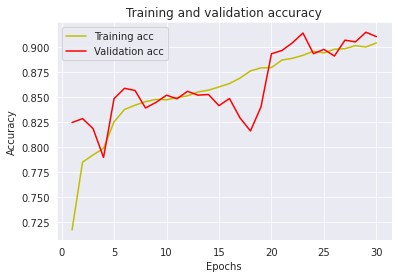

In [ ]:
# 훈련 및 검증 정확도와 각 에포크 마다의 손실 그래프 출력

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#4.모델로딩

In [24]:
# Unet 모델 함수 생성 및 인스턴스 Unet 모델 생성

IMG_HEIGHT = 448
IMG_WIDTH  = 592
IMG_CHANNELS = 3
DROPOUT = 0.3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, DROPOUT):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    # c1 = BatchNormalization()(c1)
    c1 = Dropout(DROPOUT)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    # c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    # c2 = BatchNormalization()(c2)
    c2 = Dropout(DROPOUT)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    # c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    # c3 = BatchNormalization()(c3)
    c3 = Dropout(DROPOUT)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    # c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    # c4 = BatchNormalization()(c4)
    c4 = Dropout(DROPOUT)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    # c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    # c5 = BatchNormalization()(c5)
    c5 = Dropout(DROPOUT)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # c5 = BatchNormalization()(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    # c6 = BatchNormalization()(c6)
    c6 = Dropout(DROPOUT)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    # c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    # c7 = BatchNormalization()(c7)
    c7 = Dropout(DROPOUT)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    # c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    # c8 = BatchNormalization()(c8)
    c8 = Dropout(DROPOUT)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    # c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    # c9 = BatchNormalization()(c9)
    c9 = Dropout(DROPOUT)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    # c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, DROPOUT)

model = get_model()


# 모델 로딩
model.load_weights('/content/drive/MyDrive/Colab Notebooks/new_data_v3/skin_seg_models/segmentation_skincance_img450*600*3_data_simpleUNET_train_img_900_valid_img_451_batch16_epoch30_dropout0.3.hdf5') #Trained for 50 epochs and then additional 100
# model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 592, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 592, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 448, 592, 16  0           ['conv2d[0][0]']                 
                                )                                                             

#5.테스트 데이터 로딩 및 모델평가, 임계값에 따른 IOU 최적화

In [25]:
# 테스트 데이터 로딩 및 사이즈 변경

image_dataset_test = []
mask_dataset_test = []

for i in test_df['image_pathes']:
  image = plt.imread(i)
  image = Image.fromarray(image.astype(np.uint8))
  image = image.resize((592, 448))
  image_dataset_test.append(np.array(image))

for j in test_df['mask_pathes']:
  mask = cv2.imread(j, 0)
  mask = Image.fromarray(mask.astype(np.uint8))
  mask = mask.resize((592, 448))
  mask_dataset_test.append(np.array(mask))

이미지 숫자[0 ~ 450] : 283


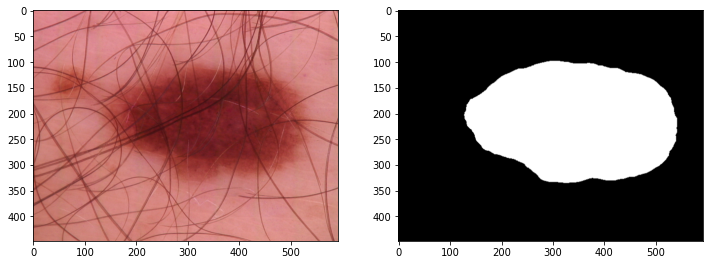

In [26]:
# 불러온 테스트 이미지 체크
import random
import numpy as np
image_number = random.randint(0, len(image_dataset_test))
plt.figure(figsize=(12, 6))
print('이미지 숫자[0 ~ {}] : {}'.format(len(image_dataset_test) - 1, image_number))
plt.subplot(121)
plt.imshow(image_dataset_test[image_number])
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset_test[image_number], (448, 592)), cmap='gray')

plt.show()

In [27]:
# 테스트 데이터 배열변환 및 정규화

image_dataset_test = np.array(image_dataset_test) / 255.
mask_dataset_test = np.expand_dims((np.array(mask_dataset_test)), 3) /255.

X_test = image_dataset_test
y_test = mask_dataset_test

print(X_test.shape, y_test.shape)

(451, 448, 592, 3) (451, 448, 592, 1)


In [ ]:
# 모델평가

_, acc = model.evaluate(X_test, y_test)
print("테스트 정확도 = {:.3f}%".format(acc * 100.0))

15/15 [==============================] - 2s 79ms/step - loss: 0.2219 - accuracy: 0.9113
테스트 정확도 = 91.129%


In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.19

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU 스코어: {:.3f}".format(iou_score))

In [ ]:
# 임계값에 따른 IOU 그래프

def threshold_iou(threshold):
  y_pred=model.predict(X_test)
  y_pred_thresholded = y_pred > threshold

  intersection = np.logical_and(y_test, y_pred_thresholded)
  union = np.logical_or(y_test, y_pred_thresholded)
  iou_score = np.sum(intersection) / np.sum(union)

  return iou_score

##1].iou값이 최대인 임계값 찾기

In [ ]:
iou = {}

for i in np.linspace(0, 1, 21):
  iou[i] = threshold_iou(i)

iou

{0.0: 0.2669078517735149,
 0.05: 0.43866350131775733,
 0.1: 0.5664613673718494,
 0.15000000000000002: 0.642076035100328,
 0.2: 0.677679135620972,
 0.25: 0.6951920308900035,
 0.30000000000000004: 0.7050316296579288,
 0.35000000000000003: 0.7112068731087662,
 0.4: 0.7148842098700665,
 0.45: 0.714651312520523,
 0.5: 0.7125368043514668,
 0.55: 0.7088781935439036,
 0.6000000000000001: 0.6998785646993458,
 0.65: 0.6881486104494395,
 0.7000000000000001: 0.6699723236439569,
 0.75: 0.6473213788194332,
 0.8: 0.6251228030242646,
 0.8500000000000001: 0.6017353817896514,
 0.9: 0.5638667916593341,
 0.9500000000000001: 0.44620696657998715,
 1.0: 0.0}

In [ ]:
for i, j in iou.items():
  if j == max(iou.values()):
    print('iou가 최대일 때의 임계값 : {}, 최대 iou값 : {:.4f}'.format(i, j))

iou가 최대일 때의 임계값 : 0.4, 최대 iou값 : 0.7149


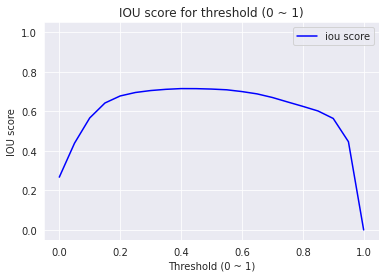

In [ ]:
plt.plot(list(iou.keys()), list(iou.values()), label = 'iou score', color = 'blue')


plt.title('IOU score for threshold (0 ~ 1)')
plt.xlabel('Threshold (0 ~ 1)')
plt.ylabel('IOU score')

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

# 눈금 간격 1로 변경(x, y축 모두)
# plt.xticks(0.05)
# plt.yticks(0.05)

plt.legend()
plt.show()

# # threshold가 0.4인 지점에서 iou score가 0.7148842098700665로 최대값을 나타냄

In [28]:
# 딥러닝 모델의 segmentation 예측

# model = get_model()
# model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

# test_img_number = random.randint(0, len(X_test))

# test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
# # test_img_norm=test_img[:,:,0][:,:,None]
# test_img_input=np.expand_dims(test_img, 0)
# prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

def segmentation_predict(image_data, mask_data):
  test_img_number = random.randint(0, len(image_data))
  print('테스트 이미지 숫자(0 ~ {}) : {}'.format(len(image_data), test_img_number))
  test_img = image_data[test_img_number]
  ground_truth = mask_data[test_img_number]
  # test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.4).astype(np.uint8)


  external_image = []

  test_img_other = plt.imread('/content/drive/MyDrive/Colab Notebooks/Section6_CP2_project/ham10000_dataset/new_data_v2/new_data_v2_images/test/NV/ISIC_0025822.jpg')
  #test_img_other = cv2.imread('data/test_images/img8.tif', 0)
  test_img_other = Image.fromarray(test_img_other)
  test_img_other = test_img_other.resize((592, 448))

  external_image.append(np.array(test_img_other))
  # plt.imshow(external_image[0])
  external_image_input = np.array(external_image) / 255.
  prediction_other = (model.predict(external_image_input)[0,:,:,0] > 0.4).astype(np.uint8)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction, cmap='gray')
  plt.subplot(234)
  plt.title('External Image')
  plt.imshow(test_img_other)
  plt.subplot(235)
  plt.title('Prediction of external Image')
  plt.imshow(prediction_other, cmap='gray')
  plt.show()

테스트 이미지 숫자(0 ~ 451) : 191
1/1 [==============================] - 0s 23ms/step


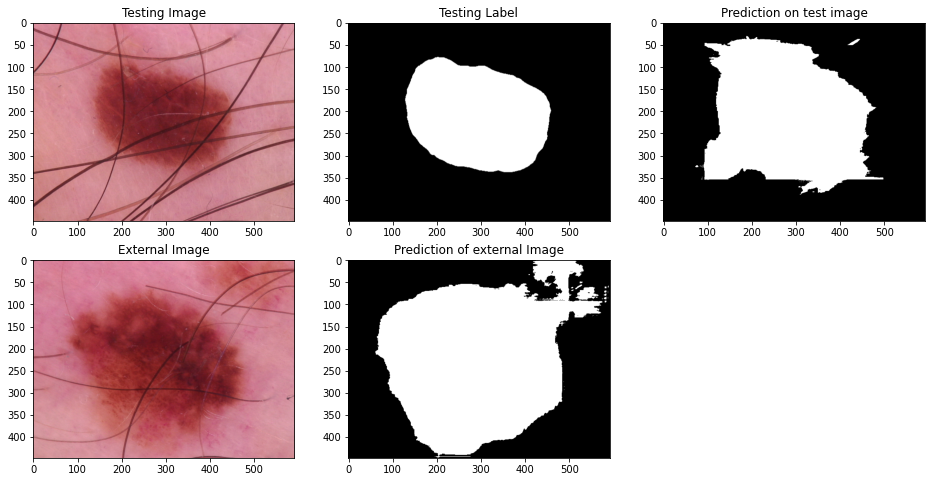

In [36]:
segmentation_predict(X_test, y_test)

#6.이미지 만들기

In [ ]:
def make_lesion_images(image_data):
  SIZE = 256
  image_list = []

  image_data_input = plt.imread(image_data)
  image_data_input = Image.fromarray(image_data_input)
  image_data_input = image_data_input.resize((592, 448))
  image_data_input = np.array(image_data_input) /255.

  image_list.append(image_data_input)
  # plt.imshow(external_image[0])
  external_image_input = np.array(image_list)
  predict = (model.predict(external_image_input) > 0.4).astype(np.uint8) # 0.5를 기점으로 array의 element를 0 또는 1로 만들어 줌
  predict2 = np.stack((predict[:, :, :, 0], predict[:, :, :, 0], predict[:, :, :, 0]), axis=3) * 255 # (None, 256, 256, 1)의 배열을 (None, 256, 256, 3)로 만들어 줌
  

  # print(image_data.shape, image_data_255.shape)
  
  external_image_input_255 = (external_image_input*255).astype(np.uint8)
  external_image_input_255 = external_image_input_255[0]
  new_image = np.empty_like(external_image_input_255)

  for i in range(external_image_input_255.shape[0]):
    for j in range(external_image_input_255.shape[1]):
      for k in range(external_image_input_255.shape[2]):
        prd = predict2[0]
        if external_image_input_255[i][j][k] >= prd[i][j][k]:
          new_image[i][j][k] = prd[i][j][k]

        else:
          new_image[i][j][k] = external_image_input_255[i][j][k]  
  
  return new_image

# for i in range(len(X_train)):
#   X_train_new.append(make_lesion_images(X_train, i))
#   plt.imsave('/content/drive/MyDrive/Colab Notebooks/new_data_v3/images_segmented/{}'.format(train_df['image_pathes'].iloc[i].split('s/')[-1]), X_train_new[i])


for image_data in df['image_pathes']:
  save_image = make_lesion_images(image_data)
  plt.imsave('/content/drive/MyDrive/Colab Notebooks/new_data_v3/images_segmented_v2/{}'.format(image_data.split('s/')[-1]), save_image)
# 약 10000개 이미지 만드는 데 2시간 41분 7초 걸림....

In [ ]:
mel_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/new_data_v3/images_segmented_v2/MEL')
nv_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/new_data_v3/images_segmented_v2/NV')
oth_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/new_data_v3/images_segmented_v2/Other_SC')

print('segmented된 이미지 데이터의 총 개수 : {}\nMEL 개수 : {}\nNV 개수 : {}\nOther_SC 개수 : {}'.format(len(mel_list) + len(nv_list) + len(oth_list), len(mel_list), len(nv_list), len(oth_list)))

segmented된 이미지 데이터의 총 개수 : 10015
MEL 개수 : 1113
NV 개수 : 6705
Other_SC 개수 : 2197


In [ ]:
len(df)

10015

In [ ]:
# BCC : 514
# AKIEC : 327
# BKL : 1099
# DF : 115
# VASC : 142

514 + 327 + 1099 + 115 + 142